# Homework 3 - Berkeley STAT 157

Handout 2/5/2019, due 2/12/2019 by 4pm in Git by committing to your repository.

**Formatting: please include both a .ipynb and .pdf file in your homework submission, named homework3.ipynb and homework3.pdf. You can export your notebook to a pdf either by File -> Download as -> PDF via Latex (you may need Latex installed), or by simply printing to a pdf from your browser (you may want to do File -> Print Preview in jupyter first). Please don't change the filename.**       

In [5]:
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt
from mxnet import nd
from mxnet.gluon import loss as gloss
from mxnet import init
from mxnet.gluon import nn
from mxnet.gluon import data as gdata
import numpy as np

# 1. Logistic Regression for Binary Classification

In multiclass classification we typically use the exponential model 

$$p(y|\mathbf{o}) = \mathrm{softmax}(\mathbf{o})_y = \frac{\exp(o_y)}{\sum_{y'} \exp(o_{y'})}$$

1.1. Show that this parametrization has a spurious degree of freedom. That is, show that both $\mathbf{o}$ and $\mathbf{o} + c$ with $c \in \mathbb{R}$ lead to the same probability estimate.
1.2. For binary classification, i.e. whenever we have only two classes $\{-1, 1\}$, we can arbitrarily set $o_{-1} = 0$. Using the shorthand $o = o_1$ show that this is equivalent to 

$$p(y=1|o) = \frac{1}{1 + \exp(-o)}$$

1.3. Show that the log-likelihood loss (often called logistic loss) for labels $y \in \{-1, 1\}$ is thus given by 

$$-\log p(y|o) = \log (1 + \exp(-y \cdot o))$$

1.4. Show that for $y = 1$ the logistic loss asymptotes to $o$ for $o \to \infty$ and to $\exp(o)$ for $o \to -\infty$. 

![](WechatIMG15.jpg)

# 2. Logistic Regression and Autograd

1. Implement the binary logistic loss $l(y,o) = \log (1 + \exp(-y \cdot o))$ in Gluon
1. Plot its values for $y \in \{-1, 1\}$ over the range of $o \in [-5, 5]$.
1. Plot its derivative with respect to $o$ for $o \in [-5, 5]$ using 'autograd'.

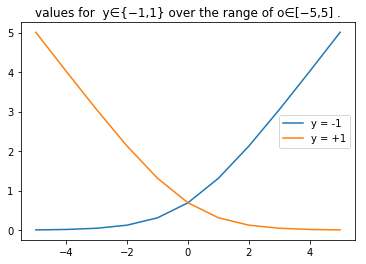

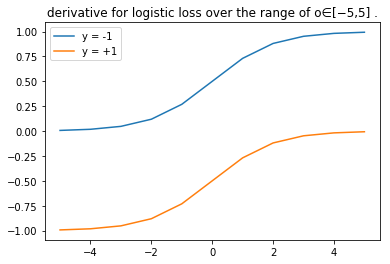

In [22]:
def loss(y,o):
    ## add your loss function here
    l = nd.log(1+nd.exp(-y*o))
    return l
#2
o = nd.arange(-5, 6)
o1 = nd.arange(-5, 6)
neg_loss = loss(-1, o)
pos_loss = loss(1, o)

plt.figure()
plt.plot(o.asnumpy(), neg_loss.asnumpy(), label = 'y = -1')
plt.plot(o.asnumpy(), pos_loss.asnumpy(), label = 'y = +1')
plt.title("values for  y∈{−1,1} over the range of o∈[−5,5] .")
plt.legend()
plt.show()

#3
o.attach_grad()
o1.attach_grad()
with autograd.record():
    neg_loss = loss(-1, o)
    pos_loss = loss(1, o1)
neg_loss.backward()
pos_loss.backward()

plt.figure()
plt.plot(o.asnumpy(), o.grad.asnumpy(), label = 'y = -1')
plt.plot(o.asnumpy(), o1.grad.asnumpy(), label = 'y = +1')
plt.title("derivative for logistic loss over the range of o∈[−5,5] .")
plt.legend()
plt.show()


# 3. Ohm's Law

Imagine that you're a young physicist, maybe named [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm), trying to figure out how current and voltage depend on each other for resistors. You have some idea but you aren't quite sure yet whether the dependence is linear or quadratic. So you take some measurements, conveniently given to you as 'ndarrays' in Python. They are indicated by 'current' and 'voltage'.

Your goal is to use least mean squares regression to identify the coefficients for the following three models using automatic differentiation and least mean squares regression. The three models are:

1. Quadratic model where $\mathrm{voltage} = c + r \cdot \mathrm{current} + q \cdot \mathrm{current}^2$.
1. Linear model where $\mathrm{voltage} = c + r \cdot \mathrm{current}$.
1. Ohm's law where $\mathrm{voltage} = r \cdot \mathrm{current}$.

In [6]:
current = nd.array([1.5420291, 1.8935232, 2.1603365, 2.5381863, 2.893443, \
                    3.838855, 3.925425, 4.2233696, 4.235571, 4.273397, \
                    4.9332876, 6.4704757, 6.517571, 6.87826, 7.0009003, \
                    7.035741, 7.278681, 7.7561755, 9.121138, 9.728281])
voltage = nd.array([63.802246, 80.036026, 91.4903, 108.28776, 122.781975, \
                    161.36314, 166.50816, 176.16772, 180.29395, 179.09758, \
                    206.21027, 272.71857, 272.24033, 289.54745, 293.8488, \
                    295.2281, 306.62274, 327.93243, 383.16296, 408.65967])


In [7]:
#1
batch_size = 10
cur = current.asnumpy()
X = np.column_stack((cur,cur**2))
X = nd.array(X)
dataset = gdata.ArrayDataset(X, voltage)
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)

net = nn.Sequential()
net.add(nn.Dense(1))
net.initialize(init.Normal(sigma=0.01))

loss = gloss.L2Loss()  # The squared loss is also known as the L2 norm loss

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.001})

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    l = loss(net(X), voltage)
    print('epoch %d, loss: %f' % (epoch, l.mean().asnumpy()))


epoch 1, loss: 4122.698242
epoch 2, loss: 7665.683594
epoch 3, loss: 12165.678711
epoch 4, loss: 17861.550781
epoch 5, loss: 17319.964844
epoch 6, loss: 12842.038086
epoch 7, loss: 16076.669922
epoch 8, loss: 15966.548828
epoch 9, loss: 8843.123047
epoch 10, loss: 7690.440430


In [11]:
w = net[0].weight.data()
b = net[0].bias.data()
w,b

(
 [[2.4000096 4.828865 ]]
 <NDArray 1x2 @cpu(0)>, 
 [0.7911238]
 <NDArray 1 @cpu(0)>)

In [121]:
#2

# Combine the features and labels of the training data
dataset = gdata.ArrayDataset(current, voltage)
# Randomly reading mini-batches
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)

net2 = nn.Sequential()
net2.add(nn.Dense(1))
net2.initialize(init.Normal(sigma=0.01))


trainer = gluon.Trainer(net2.collect_params(), 'sgd', {'learning_rate': 0.03})

# for X, y in data_iter:
#     print(X, y)
#     break

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        with autograd.record():
            l = loss(net2(X), y)
        l.backward()
        trainer.step(batch_size)
    l = loss(net2(current), voltage)
    print('epoch %d, loss: %f' % (epoch, l.mean().asnumpy()))

epoch 1, loss: 245.342743
epoch 2, loss: 4.853154
epoch 3, loss: 2.461826
epoch 4, loss: 2.395899
epoch 5, loss: 2.368906
epoch 6, loss: 2.362000
epoch 7, loss: 2.321449
epoch 8, loss: 2.358670
epoch 9, loss: 2.312108
epoch 10, loss: 2.394593


In [122]:
w = net2[0].weight.data()
b = net2[0].bias.data()
current * w + b


[[ 68.70281  83.25118  94.2946  109.93384 124.63795 163.76863 167.35176
  179.68372 180.18874 181.75435 209.06728 272.69162 274.6409  289.56985
  294.64594 296.08798 306.14328 325.90683 382.4027  407.53244]]
<NDArray 1x20 @cpu(0)>

In [123]:
#3
net3 = nn.Sequential()
net3.add(nn.Dense(1,use_bias=False))
net3.initialize()
trainer = gluon.Trainer(net3.collect_params(), 'sgd', {'learning_rate': 0.03})

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        with autograd.record():
            l = loss(net3(X), y)
        l.backward()
        trainer.step(batch_size)
    l = loss(net3(current), voltage)
    print('epoch %d, loss: %f' % (epoch, l.mean().asnumpy()))

epoch 1, loss: 0.857494
epoch 2, loss: 0.617405
epoch 3, loss: 0.644614
epoch 4, loss: 0.699233
epoch 5, loss: 0.611505
epoch 6, loss: 0.617225
epoch 7, loss: 0.612036
epoch 8, loss: 0.654889
epoch 9, loss: 0.617132
epoch 10, loss: 0.643549


In [124]:
w = net3[0].weight.data()
current * w


[[ 64.78331   79.550186  90.759476 106.6336   121.55855  161.27695
  164.9139   177.43106  177.94366  179.5328   207.25595  271.83588
  273.81442  288.96762  294.11993  295.58365  305.78998  325.85034
  383.19476  408.7019  ]]
<NDArray 1x20 @cpu(0)>

# 4. Entropy

Let's compute the *binary* entropy of a number of interesting data sources. 

1. Assume that you're watching the output generated by a [monkey at a typewriter](https://en.wikipedia.org/wiki/File:Chimpanzee_seated_at_typewriter.jpg). The monkey presses any of the $44$ keys of the typewriter at random (you can assume that it has not discovered any special keys or the shift key yet). How many bits of randomness per character do you observe?
1. Unhappy with the monkey you replaced it by a drunk typesetter. It is able to generate words, albeit not coherently. Instead, it picks a random word out of a vocabulary of $2,000$ words. Moreover, assume that the average length of a word is $4.5$ letters in English. How many bits of randomness do you observe now?
1. Still unhappy with the result you replace the typesetter by a high quality language model. These can obtain perplexity numbers as low as 20 points per character. The perplexity is defined as a length normalized probability, i.e.

$$\mathrm{PPL}(x) = \left[p(x)\right]^{1/\mathrm{length}(x)}$$

In [20]:
def Hp(p):
    return sum(-ProbDist * np.log2(ProbDist))
#1
ProbDist = np.repeat(1/44,44) #'nat'
Hp(ProbDist)


5.4594316186372955

In [25]:
#2
ProbDist = np.repeat(1/2000,2000)
Hp(ProbDist) * np.log2(4.5)

23.794929479711104

In [ ]:
#3
#insufficient

# 5. Wien's Approximation for the Temperature (bonus)

We will now abuse Gluon to estimate the temperature of a black body. The energy emanated from a black body is given by Wien's approximation.

$$B_\lambda(T) = \frac{2 h c^2}{\lambda^5} \exp\left(-\frac{h c}{\lambda k T}\right)$$

That is, the amount of energy depends on the fifth power of the wavelength $\lambda$ and the temperature $T$ of the body. The latter ensures a cutoff beyond a temperature-characteristic peak. Let us define this and plot it.

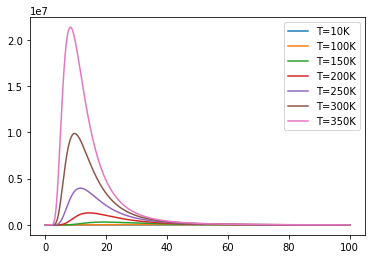

In [26]:
# Lightspeed
c = 299792458
# Planck's constant
h = 6.62607004e-34
# Boltzmann constant
k = 1.38064852e-23
# Wavelength scale (nanometers)
lamscale = 1e-6
# Pulling out all powers of 10 upfront
p_out = 2 * h * c**2 / lamscale**5
p_in = (h / k) * (c/lamscale) 

# Wien's law
def wien(lam, t):
    return (p_out / lam**5) * nd.exp(-p_in / (lam * t))

# Plot the radiance for a few different temperatures
lam = nd.arange(0,100,0.01)
for t in [10, 100, 150, 200, 250, 300, 350]:
    radiance = wien(lam, t)
    plt.plot(lam.asnumpy(), radiance.asnumpy(), label=('T=' + str(t) + 'K'))
plt.legend()
plt.show()

Next we assume that we are a fearless physicist measuring some data. Of course, we need to pretend that we don't really know the temperature. But we measure the radiation at a few wavelengths.  

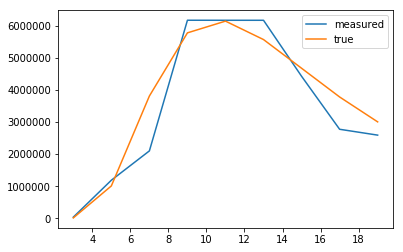

In [27]:
# real temperature is approximately 0C
realtemp = 273
# we observe at 3000nm up to 20,000nm wavelength
wavelengths = nd.arange(3,20,2)
# our infrared filters are pretty lousy ...
delta = nd.random_normal(shape=(len(wavelengths))) * 1

radiance = wien(wavelengths + delta, realtemp)
plt.plot(wavelengths.asnumpy(), radiance.asnumpy(), label='measured')
plt.plot(wavelengths.asnumpy(), wien(wavelengths, realtemp).asnumpy(), label='true')
plt.legend()
plt.show()

Use Gluon to estimate the real temperature based on the variables `wavelengths` and `radiance`. 

* You can use Wien's law implementation `wien(lam,t)` as your forward model. 
* Use the loss function $l(y,y') = (\log y - \log y')^2$ to measure accuracy.

In [65]:
def loss_function(y, yhat):
    l = (nd.log(y) - nd.log(yhat)) ** 2
    return l

In [66]:
loss = loss_function

In [95]:
num_epochs = 20
#inital temp as 200, then use gradient descent to "move" it and find an estimate temp that is closest to real temp
temp = nd.random.normal(200, 5)  
learning_rate = 5
temp.attach_grad()
delta_temp = []
delta_temp.append(temp.asscalar())
for epoch in range(1, num_epochs+1):
    with autograd.record():
        y = wien(wavelengths, temp)
        l = loss(radiance, y)
    l.backward()
    temp -= learning_rate * temp.grad
    delta_temp.append(temp.asscalar())
    l = loss(radiance, wien(wavelengths, temp))
    print('epoch {0}, loss {1}'.format(epoch, l.mean().asnumpy()))


epoch 1, loss [4.8184185]
epoch 2, loss [3.3059504]
epoch 3, loss [2.4110065]
epoch 4, loss [1.8309377]
epoch 5, loss [1.4324774]
epoch 6, loss [1.1474382]
epoch 7, loss [0.9373245]
epoch 8, loss [0.77881837]
epoch 9, loss [0.6570287]
epoch 10, loss [0.5620459]
epoch 11, loss [0.48705006]
epoch 12, loss [0.42721996]
epoch 13, loss [0.37906438]
epoch 14, loss [0.34001338]
epoch 15, loss [0.3081355]
epoch 16, loss [0.2819658]
epoch 17, loss [0.26037323]
epoch 18, loss [0.24247745]
epoch 19, loss [0.2275882]
epoch 20, loss [0.2151568]


In [96]:
#our estimate
temp.asscalar()

271.70236

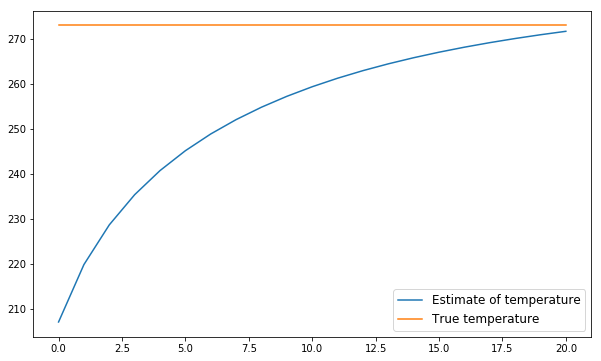

In [106]:
plt.figure(figsize=(10,6))
plt.plot(range(len(delta_temp)), delta_temp, label="Estimate of temperature")
plt.plot([273]*(num_epochs+1), label = "True temperature")
plt.legend(fontsize = 'large')
plt.show()

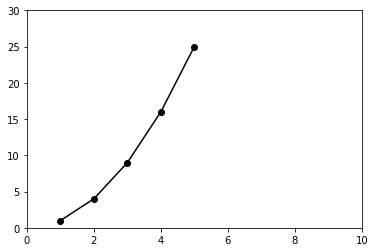

In [158]:
# a = np.array([1,2,3,4,5])
# #plt.plot(a, a**2,'o')
# plt.plot(a, a**2,'-ok')
# plt.ylim(0, 30)
# plt.xlim(0,10)
# plt.show()